In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from typhon import plots
import xarray as xr
from scipy import integrate
from scipy import optimize

import konrad

plots.styles.use('typhon')

In [2]:
cp_air = 1004.64 #J kg-1 K-1
g = 9.81 #m s-2
Ra = 287.0570048852906 #J kg-1 K-1 air
print(konrad.constants.Rv)
Rv = 461.52280830495 #J kg-1 K-1 water vapor
Lv = 2.5E6 #J kg-1
eps = Ra/Rv #dimensionless
e_sat_ref = 610.94 #Pa, saturation water vapor pressure for Tref = 273.15 K
T_ref = 273.15 #K
seconds_day = 24*60*60 #seconds in a day

lapse_dry = -g/cp_air #K/m

461.52280830495


In [3]:
#WATER

def manabe_rh(rhs, p):
    rh = np.maximum(0,rhs*(p/p[0]-0.02)/(1-0.02))
    return rh

def fixed_rh(rhs,p):
    rh = np.ones_like(p)*rhs
    return rh

def w_sat_p(T): #Pa
    e_sat = e_sat_ref * np.exp(-Lv/Rv*(1/T-1/T_ref))
    return e_sat

def mmr_sat(T,p): #kg/kg
    r_sat = eps*w_sat_p(T)/p
    return r_sat

def vmr_sat(T,p): #m3/m3
    r_sat = w_sat_p(T)/p
    return r_sat
    
def rh_to_mmr(rh,T,p):
    mixing_saturation = mmr_sat(T,p)
    mixing_ratio = np.maximum(5e-6,rh*mixing_saturation)
    
    return mixing_ratio

def rh_to_vmr(rh,T,p):
    mixing_ratio = np.maximum(5e-6,konrad.physics.relative_humidity2vmr(rh,p,T))
    
    return mixing_ratio

def vmr_to_rh(vmr,T,p):
    relative_humidity = konrad.physics.vmr2relative_humidity(vmr,p,T)
    
    return relative_humidity

def vmr_to_mmr(vmr):
    mass_mix = vmr*eps
    
    return mass_mix

def energy_to_water(energy):#kg m-2
    #if energy is in J s-1 m-2, comes back as kg s-1 m-2, ie, mm s-1 of precipitation
    # mass_atm = (p[0]-p[-1])/g
    mass_w = energy/Lv #* mass_atm
    return mass_w

In [4]:
#AIR

def height(p,T): #m
    rho = p/(Ra*T)
    z = integrate.cumulative_trapezoid(-1/(g*rho),p,initial = 0)
    return z

def MALR(T,p): #dlnT/dlnp
    r_sat = mmr_sat(T,p)
    A = (Lv*r_sat)/(Ra*T)
    B = (Lv**2*r_sat)/(cp_air*Ra*T**2)
    moist_lapse = - g/cp_air * (1+A)/(1+B)
    return moist_lapse

def T_MA(T_bl,p): #K
    T_atm = np.zeros((len(p)))
    T_atm[0] = T_bl
    for i in range(len(p)-1):
        lapse_z = MALR(T_atm[i],p[i])
        lapse_p = lapse_pressure(lapse_z)
        T_atm[i+1]=T_atm[i]*(p[i+1]/p[i])**(lapse_p)
    return T_atm

def lapse_pressure(lapse_z): #dlnT/dlnp, dT/dz
    l_p = -Ra/g * lapse_z
    return l_p


def T_atm_z(T_bl,z,lapse_z):
    Temp = T_bl + z*lapse_z
    return Temp

def T_atm_p(T_bl,p,lapse_p):
    Temp = T_bl * (p/p_s)**(lapse_p)
    return Temp

def moist_adiabat(p,T_bl,T_rad):
    T_moist_ad = konrad.lapserate.get_moist_adiabat(p,T_bl,T_min=0.)
    T_con = np.maximum(T_moist_ad,T_rad)
    
    return T_con

In [25]:
#FIRE

def TE(T,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy #J kg-1

def DSE(T,z,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def PE(z):
    energy = integrate.trapz(-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass

def T_bl_TE(thermal_energy, p, T_rad): #find T_bl conserving thermal energy
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl


def T_convection_TE(p, T_rad, SH): #find T after convective adjustment conserving thermal energy
    thermal_energy = TE(T_rad,p) + SH
    
    def fun(T_bl):
        T_atm = moist_adiabat(p,T_bl,T_rad)
        TE_moist = TE(T_atm,p)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    T_con = moist_adiabat(p,T_bl,T_rad)
    return T_con


def T_convection_DSE(p, T_rad, SH): #find T after convective adjustment conserving dry static energy
    z_rad = height(p,T_rad) + SH
    dry_static_energy = DSE(T_rad,z_rad,p)
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        z_atm = height(p,T_atm)
        DSE_moist = DSE(T_atm,z_atm,p)
        res = DSE_moist-dry_static_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl

In [18]:
#EARTH

wind = 10 # wind speed m s-1
Cd = 0.001 # Drag coefficient unitless

def sensible_heat(T_bl,T_s,p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Ra*T_bl) #kg m-3
    sh = wind*Cd*rho_s*cp_air*(T_s-T_bl) #J s-1 m-2
    
    return sh

def latent_heat(vmr, T_bl, p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Ra*T_bl) #kg m-3
    
    rh = konrad.physics.vmr2relative_humidity(vmr,p_s,T_bl)
    mmr = vmr_to_mmr(vmr)
    mmr_sat = mmr/rh
    
    lh = wind*Cd*rho_s*Lv*(mmr_sat-mmr) #J s-1 m-2
    return lh
    
    
    

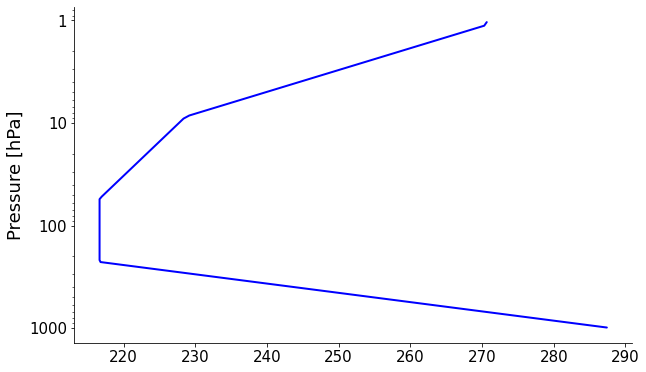

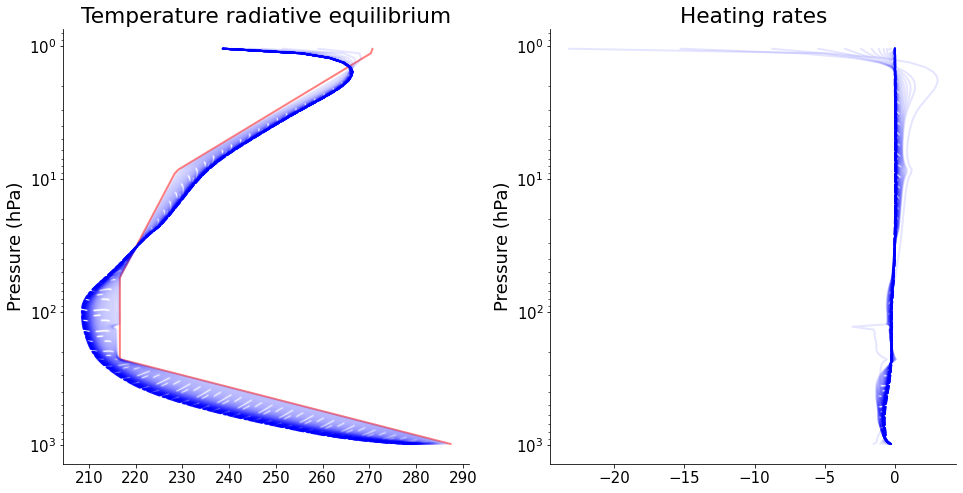

[288.76475605]


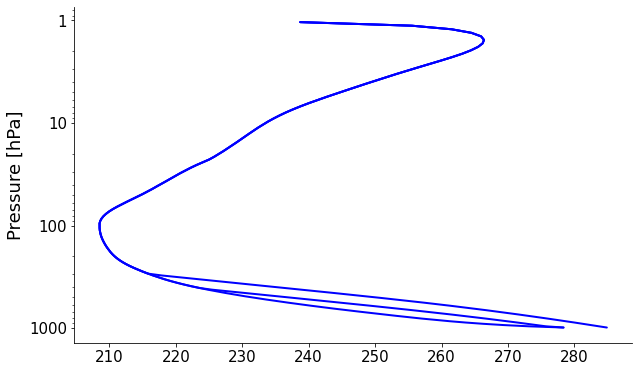

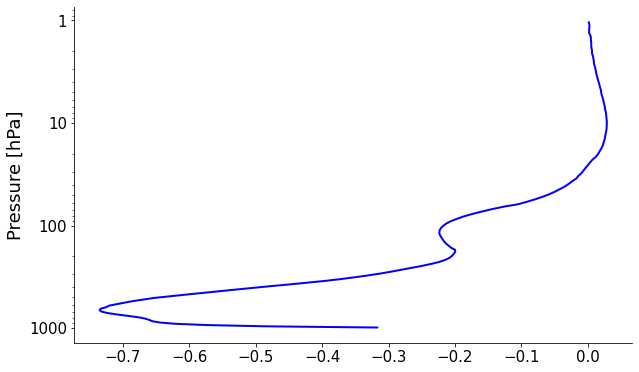

In [19]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()

RH = manabe_rh(0.77,atmosphere['plev'])


fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['T'][0], color = 'blue')
plt.show()

nsteps = 50
timestep = 0.5 #days

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_yscale('log')
ax[0].yaxis.set_inverted(True)
ax[0].set_title('Temperature radiative equilibrium')
ax[0].set_ylabel('Pressure (hPa)')



ax[1].set_yscale('log')
ax[1].set_title('Heating rates')
ax[1].set_ylabel('Pressure (hPa)')
ax[1].yaxis.set_inverted(True)

ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red')

for i in range(nsteps):
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    surface['temperature'] += (net_rad_surface - surface.heat_sink) * 60*60*24 * timestep / surface.heat_capacity
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])
    
    alpha = 0.1+0.8*(i/nsteps)**4
    ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = alpha, color = 'blue')

    
    ax[1].plot(radiation['net_htngrt'][0], atmosphere['plev']/100,
               alpha = alpha, color = 'blue')


plt.show()

print(surface['temperature'])
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['T'][0], color = 'blue')
plots.profile_p_log(atmosphere['plev'], 
                        moist_adiabat(atmosphere['plev'],atmosphere['T'][0,0],atmosphere['T'][0]), color = 'blue')
plots.profile_p_log(atmosphere['plev'], 
                        moist_adiabat(atmosphere['plev'],286,atmosphere['T'][0]), color = 'blue')
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        radiation['net_htngrt'][0], color = 'blue')
plt.show()

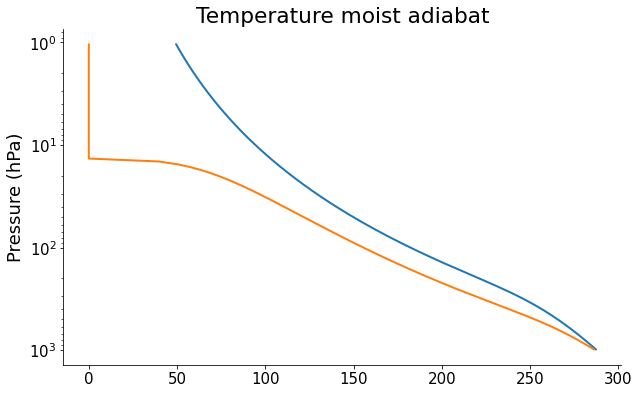

In [20]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature moist adiabat')
ax.set_ylabel('Pressure (hPa)')

T_mine = T_MA(atmosphere['T'][0,0],atmosphere['plev'])
T_kon = konrad.lapserate.get_moist_adiabat(atmosphere['plev'],atmosphere['T'][0,0],T_min=0.)
plt.plot(T_mine,atmosphere['plev']/100, label='my adiabat')
plt.plot(T_kon,atmosphere['plev']/100, label='konrad adiabat')
plt.show()

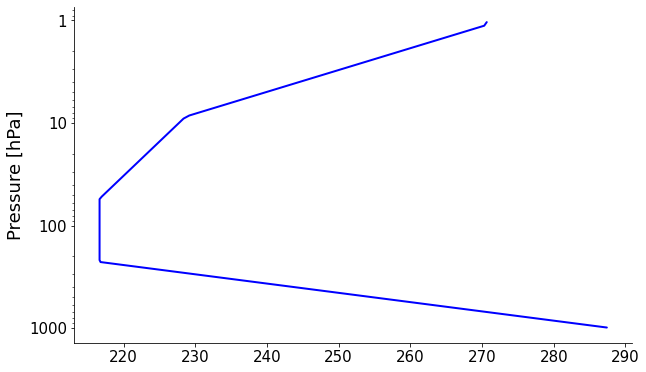

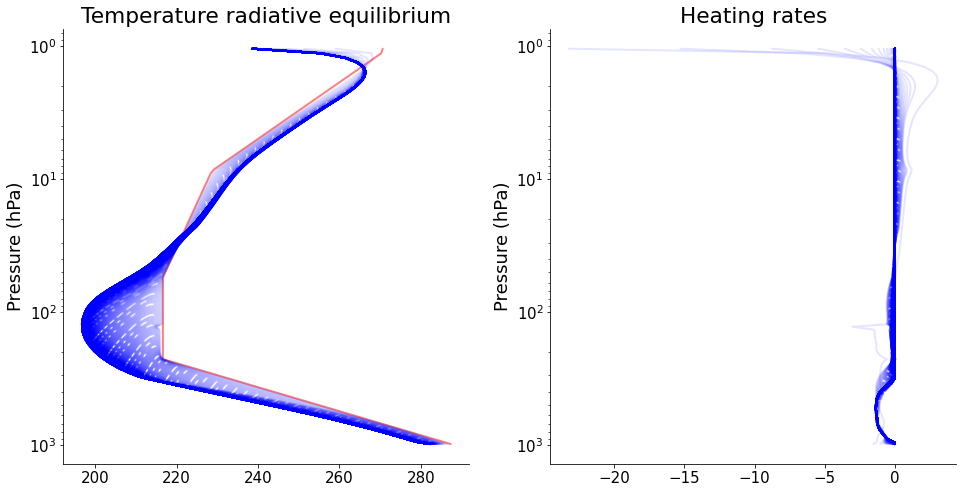

surface T [288.63652514]
toa radiation [67.33787589]
bl temp 282.5242816784131


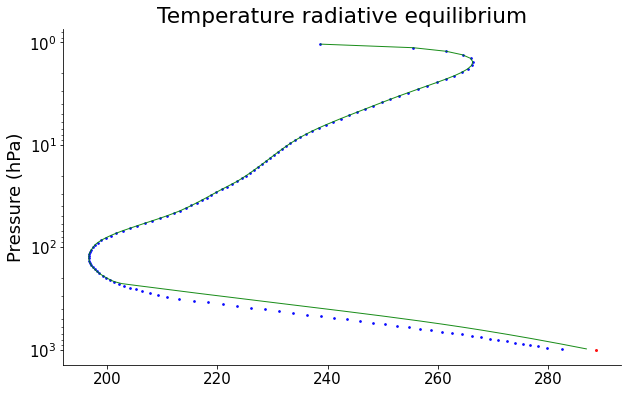

In [29]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()

RH = manabe_rh(0.77,atmosphere['plev'])


fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['T'][0], color = 'blue')
plt.show()

nsteps = 500
timestep = 0.5 #days

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_yscale('log')
ax[0].yaxis.set_inverted(True)
ax[0].set_title('Temperature radiative equilibrium')
ax[0].set_ylabel('Pressure (hPa)')



ax[1].set_yscale('log')
ax[1].set_title('Heating rates')
ax[1].set_ylabel('Pressure (hPa)')
ax[1].yaxis.set_inverted(True)

ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red')

for i in range(nsteps):
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)

    
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    SH = sensible_heat(atmosphere['T'][0,0],surface['temperature'],atmosphere['phlev'][0])
    surface['temperature'] += ((net_rad_surface - surface.heat_sink - SH)
                               * seconds_day * timestep / surface.heat_capacity)
    
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    
    T_radiation = atmosphere['T'][0].copy()
    
    atmosphere['T'][0] = T_convection_TE(atmosphere['plev'], T_radiation, SH * seconds_day * timestep)
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])
    
    alpha = 0.1+0.8*(i/nsteps)**4
    ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = alpha, color = 'blue')

    
    ax[1].plot(radiation['net_htngrt'][0], atmosphere['plev']/100,
               alpha = alpha, color = 'blue')


plt.show()

print('surface T',surface['temperature'])
print('toa radiation',radiation['toa'])
print('bl temp',atmosphere['T'][0,0])

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature radiative equilibrium')
ax.set_ylabel('Pressure (hPa)')
ax.scatter(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = alpha, color = 'blue', s = 3)
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = alpha, color = 'red', s = 4)
ax.plot(moist_adiabat(atmosphere['plev'],288,atmosphere['T'][0]), atmosphere['plev']/100,
               alpha = alpha, color = 'green', lw = 1)
plt.show()

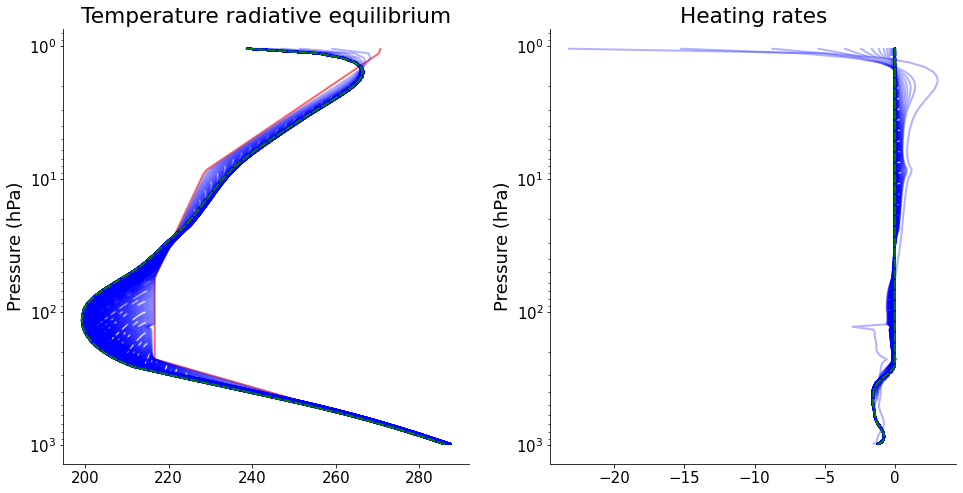

surface T [286.55184405]
toa radiation [67.50351328]
toa -67.5035132819296
surface radiation 168.000146320751
latent heat [71.92336958]
sensible heat [6.8163274]
daily evaporation [2.48567165]


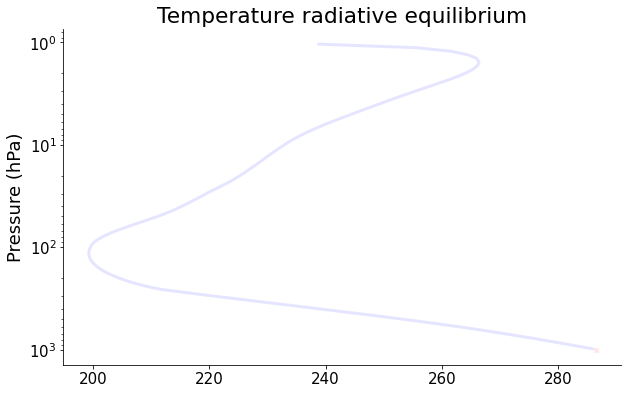

In [10]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

RH = manabe_rh(0.77,atmosphere['plev'])

ndays = 500
timestep = 0.5 #days
nsteps = int(ndays/timestep)

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_yscale('log')
ax[0].yaxis.set_inverted(True)
ax[0].set_title('Temperature radiative equilibrium')
ax[0].set_ylabel('Pressure (hPa)')



ax[1].set_yscale('log')
ax[1].set_title('Heating rates')
ax[1].set_ylabel('Pressure (hPa)')
ax[1].yaxis.set_inverted(True)

ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.6, color = 'red')

for i in range(nsteps):
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)

    
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
    SH = sensible_heat(atmosphere['T'][0,0],surface['temperature'],atmosphere['phlev'][0])
    
    LH = latent_heat(atmosphere['H2O'][0,0], surface['temperature'],atmosphere['phlev'][0])
    
    surface['temperature'] += ((net_rad_surface - LH - SH)
                               * seconds_day * timestep / surface.heat_capacity)
    
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    T_radiation = atmosphere['T'][0]
    
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )
    
    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])
    
    trans = 0.3 #+0.6*(i/nsteps)**8
    ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.3, color = 'blue')

    
    ax[1].plot(radiation['net_htngrt'][0], atmosphere['plev']/100,
               alpha = 0.3, color = 'blue')

ax[0].plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 1, color = 'green')

    
ax[1].plot(radiation['net_htngrt'][0], atmosphere['plev']/100,
               alpha = 1, color = 'green')

plt.show()

print('surface T',surface['temperature'])
print('toa radiation',radiation['toa'])
print('toa',-(radiation['lw_flxd'][0,-1] + radiation['sw_flxd'][0,-1] - 
                    (radiation['lw_flxu'][0,-1] + radiation['sw_flxu'][0,-1])))
print('surface radiation',net_rad_surface)
print('latent heat', LH)
print('sensible heat', SH)
print('daily evaporation',energy_to_water(LH)*seconds_day)

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature radiative equilibrium')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = alpha, color = 'blue', lw = 3)
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = alpha, color = 'red', s = 20, marker ='x')
plt.show()

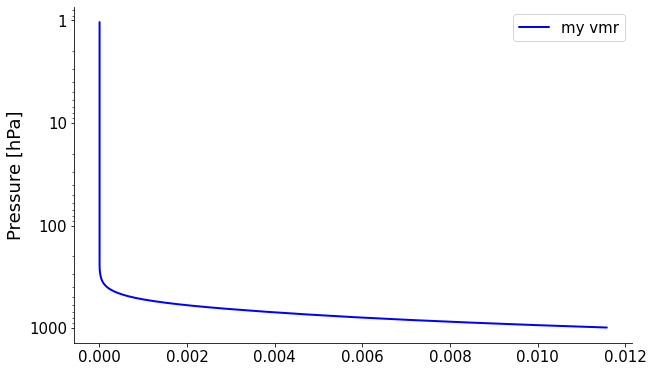

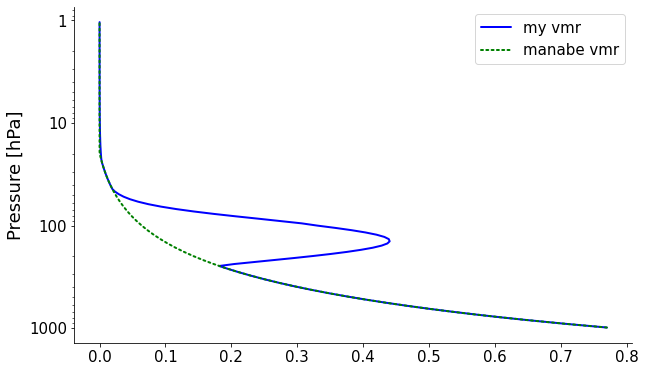

In [11]:
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['H2O'][0], color = 'blue', label = 'my vmr')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        vmr_to_rh(atmosphere['H2O'][0],atmosphere['T'][0],atmosphere['plev']),
                    color = 'blue', label = 'my vmr')
plots.profile_p_log(atmosphere['plev'], RH, 
                    color = 'green', label = 'manabe vmr', linestyle = 'dotted')
plt.legend()
plt.show()

In [12]:
y = np.linspace(2,100,30)
x = np.linspace(1,5,30)

print(integrate.trapz(y,x))

204.0
